<hr>

# AI Workflow Capstone - AAVAIL - **Part 2**

Student: `Alexey Tyurin`<br>
Date: `1/17/2024`
<hr>

### Introduction
This case study focuses on data transformations and models in time-series forecasting. Time-series data, prevalent in finance, signal processing, and weather forecasting, involves predicting future values based on past observations. This study will guide you through applying supervised learning techniques to such data, encouraging exploration of time-series modeling tools. The objective is to forecast metrics like purchases, views, or revenue, closely tied to business opportunities.

### Time-series analysis
In our time-series analysis, we primarily use TensorFlow, scikit-learn, and Spark ML for model implementation. This approach is vital for predicting future business metrics like monthly revenue. For such predictions, feature engineering is key. We can create features from past revenue data (e.g., previous day, week, month, three months) to help models like random forests or boosting algorithms identify data patterns. This feature engineering is often tailored to each specific case.

Although our current goal is to predict the next point in a time-series, considering future projections, such as three months ahead, can be beneficial. This can be done using recursive forecasting, where predictions are iteratively added to the feature matrix, or ensemble forecasting, which uses separate models for each forecast. A combination of these methods can also be effective.

It's important to note that linear regression assumptions may not hold in time-series due to auto-correlation, especially when features are mainly revenue-based and highly correlated. More sophisticated models, combined with well-crafted features, are generally more effective in this context.

### Deliverables for Data Engineering in Time-Series Forecasting:

**Feature Engineering with Rolling Window**:
- Utilize historical data, as future values (unrealized) are unknown.
Generate additional features based on historical values for each data point. This involves creating a rolling window of past data (e.g., daily, weekly, monthly) to capture trends and patterns in the historical revenue data.


**Target Value with Rolling Window**:
- Standardize the target across models to be the sum of revenues over the next 30 days for any given point in time.
In supervised learning, this target is represented as a single number, encapsulating the total forecasted revenue for the forthcoming thirty days. This approach ensures consistency and comparability across different models and forecasting techniques.

### Tasks
1. State the different modeling approaches that you will compare to address the business opportunity.
2. Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.
3. Re-train your model on all of the data using the selected approach and prepare it for deployment.
4. Articulate your findings in a summary report.

**HINT:** *To standardize the approach across models ensure that your model predicts the next 30 days for any given point in time. For supervised learning, the total revenue over the next thirty days can be represented as a single number.*

### 1. State the different modeling approaches that you will compare to address the business opportunity.

In [27]:
# Libraries

import os
import pandas as pd
import numpy as np
from cslib import fetch_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve, ShuffleSplit
import matplotlib.pyplot as plt


In [2]:
# CONSTANTS

IMAGE_DIR = os.path.join(".", "images")
DATA_TRAIN_DIR = os.path.join(".", "cs-train")
DATA_PROD_DIR = os.path.join(".", "cs-production")

In [3]:
df = fetch_data(DATA_TRAIN_DIR)

In [4]:
# Filter top 10 countries by revenue
top_countries = df.groupby('country')['price'].sum().nlargest(10).index.tolist()
filtered_df = df[df['country'].isin(top_countries)]

# Group by and aggregate
ds = filtered_df.groupby(['country', 'invoice_date']).agg(
    purchases=('invoice', 'size'),
    unique_invoices=('invoice', 'nunique'),
    unique_streams=('stream_id', 'nunique'),
    total_views=('times_viewed', 'sum'),
    revenue=('price', 'sum')
).reset_index()

# Generate a complete date range
date_range = pd.date_range(df['invoice_date'].min(), df['invoice_date'].max(), freq='1D')

# Create a DataFrame from the product of date_range and unique countries in the filtered data
complete_index = pd.MultiIndex.from_product([date_range, top_countries], names=['invoice_date', 'country'])
complete_df = pd.DataFrame(index=complete_index).reset_index()

# Merge with the aggregated DataFrame
ds = complete_df.merge(ds, on=['invoice_date', 'country'], how='left').fillna(0)

# Adding totals across all countries
totals = ds.drop(['country'], axis=1).groupby('invoice_date').sum().reset_index()
totals['country'] = 'Total'
ds = pd.concat([ds, totals])

ds.sample(5)


,invoice_date,country,purchases,unique_invoices,unique_streams,total_views,revenue
5363,2019-05-18,France,0.0,0.0,0.0,0.0,0.00
4739,2019-03-16,Netherlands,0.0,0.0,0.0,0.0,0.00
3648,2018-11-27,Singapore,0.0,0.0,0.0,0.0,0.00
890,2018-02-25,United Kingdom,1251.0,55.0,726.0,5318.0,3800.09
3549,2018-11-17,Netherlands,0.0,0.0,0.0,0.0,0.00


In [5]:
def engineer_rolling_features(X, shift_days, attributes, func='sum', engineer_target=False):
    """
    Engineer features and/or target based on a rolling window.

    Parameters:
    X (DataFrame): Input data frame.
    shift_days (int): Number of days for rolling window.
    attributes (list): List of column names to be transformed.
    func (str): Function to apply in rolling window ('sum' or 'mean').
    engineer_target (bool): If True, shift the result to engineer target.

    Returns:
    DataFrame: Transformed data frame.
    """
    X_indexed = X.set_index('invoice_date')
    freq = f'{shift_days}D'

    if func == 'sum':
        X_transformed = X_indexed[attributes].rolling(freq, closed='left').sum()
    else:
        X_transformed = X_indexed[attributes].rolling(freq, closed='left').mean()

    if engineer_target:
        X_transformed = X_transformed.shift(-shift_days)

    suffix = f'_p{freq}' if engineer_target else f'_m{freq}'
    X_transformed = X_indexed.merge(X_transformed, 
                                    left_index=True,
                                    right_index=True,
                                    how='left',
                                    suffixes=['', suffix]).fillna(0).reset_index()
    return X_transformed


In [6]:
features = ds.columns.tolist()[2:-1]
all_features = []

for country in ds['country'].unique():
    temp = ds[ds['country'] == country].drop("country", axis=1)

    # Engineer features
    for shift in [7, 14, 28, 35, 54]:
        temp = engineer_rolling_features(temp, shift, ['revenue'])
    
    temp = engineer_rolling_features(temp, 30, features, func='mean')
    
    # Engineer target
    temp = engineer_rolling_features(temp, 30, ['revenue'], engineer_target=True)

    # Drop original features and keep only engineered ones
    engineered_cols = [col for col in temp.columns if '_m' in col or '_p' in col]
    temp = temp[['invoice_date'] + engineered_cols]
    temp['country'] = country

    all_features.append(temp)

# Concatenate all countries
ds = pd.concat(all_features)

In [7]:
for sub in ds['country'].unique():
    print(sub, ds[ds['country']==sub].shape)

United Kingdom (611, 12)
EIRE (611, 12)
Germany (611, 12)
France (611, 12)
Norway (611, 12)
Spain (611, 12)
Hong Kong (611, 12)
Portugal (611, 12)
Singapore (611, 12)
Netherlands (611, 12)
Total (611, 12)


### Model Selection

For each country a model is built and trained. Since the features have different scales, we need to scale the data. The algorithms explored are:

* Stochastic Gradient Descent
* Random Forest Regressor
* Gradient Bossting Regressor
* Ada Boosting Regressor

For each algorithm we used scikit-learn `Pipeline` and `GridSearchCV` to fine tune the hyperparameters and find the optimal model.

In [54]:
def plot_learning_curve(estimator, X, y, ax=None, cv=None, n_splits=5, test_size=0.2, random_state=0):
    """
    Plot a learning curve for an sklearn estimator.
    """
    if ax is None:
        fig, ax = plt.subplots()

    if cv is None:
        cv = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    train_sizes = np.linspace(.1, 1.0, 6)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes, scoring="neg_mean_squared_error"
    )

    # Calculate means and standard deviations of training set scores
    train_scores_mean = np.mean(np.sqrt(-train_scores), axis=1)
    train_scores_std = np.std(np.sqrt(-train_scores), axis=1)

    # Calculate means and standard deviations of test set scores
    test_scores_mean = np.mean(np.sqrt(-test_scores), axis=1)
    test_scores_std = np.std(np.sqrt(-test_scores), axis=1)

    # Plot learning curve
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    # Labeling of the axes
    ax.set_xlabel("Training examples")
    ax.set_ylabel("MSE Score")
    ax.set_title("Learning Curve")
    ax.legend(loc="best")

    return ax


In [76]:
def create_learning_curves(X, y, models, country):
    """
    Create learning curves for multiple regression models.
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), facecolor="white")
    axes = axes.ravel()  # Flatten the array for easy iteration

    for idx, (model_key, ax) in enumerate(zip(models.keys(), axes)):
        regressor = models[model_key]['regressor']
        best_params = models[model_key]['grid'].best_estimator_['reg'].get_params()

        if best_params is not None:
            regressor.set_params(**best_params)

        pipeline = Pipeline(steps=[("scaler", StandardScaler()), 
                                   ("reg", regressor)])
        
        ax = plot_learning_curve(pipeline, X, y, ax)
        ax.set_title(models[model_key]['name'])
        
        if idx % 2 == 0:
            ax.set_ylabel("Performance Metric")
        if idx >= 2:
            ax.set_xlabel("Training set size")

    plt.suptitle(country)
    plt.tight_layout()
    plt.savefig(os.path.join(IMAGE_DIR, f'{country}_learning_curves.png'), format='png', dpi=300);
    #plt.show()


In [77]:
init_models = {
    'SGD': {'name': 'Stochastic Gradient Regressor',
            'regressor': SGDRegressor(random_state=42),
            'params': {'reg__penalty': ['l1', 'l2', 'elasticnet'],
                    'reg__learning_rate': ['constant', 'optimal', 'invscaling']},
            'grid': None,
            'best_params': None},
    'RFR': {'name': 'Random Forest Regressor',
            'regressor': RandomForestRegressor(random_state=42),
            'params': {'reg__n_estimators': [10, 30, 50],
                    'reg__max_features': [3, 4, 5],
                    'reg__bootstrap': [True, False]},
            'grid': None,
            'best_params': None},
    'GBR': {'name': 'Gradient Boosting Regressor',
            'regressor': GradientBoostingRegressor(random_state=42),
            'params': {'reg__n_estimators': [10, 30, 50],
                    'reg__max_features': [3, 4, 5],
                    'reg__learning_rate': [1, 0.1, 0.01, 0.001]},
            'grid': None,
            'best_params': None},
    'ABR': {'name': 'Ada Boosting Regressor',
            'regressor': AdaBoostRegressor(random_state=42),
            'params': {'reg__n_estimators': [10, 30, 50],
                    'reg__learning_rate': [1, 0.1, 0.01, 0.001]},
            'grid': None,
            'best_params': None}
    }

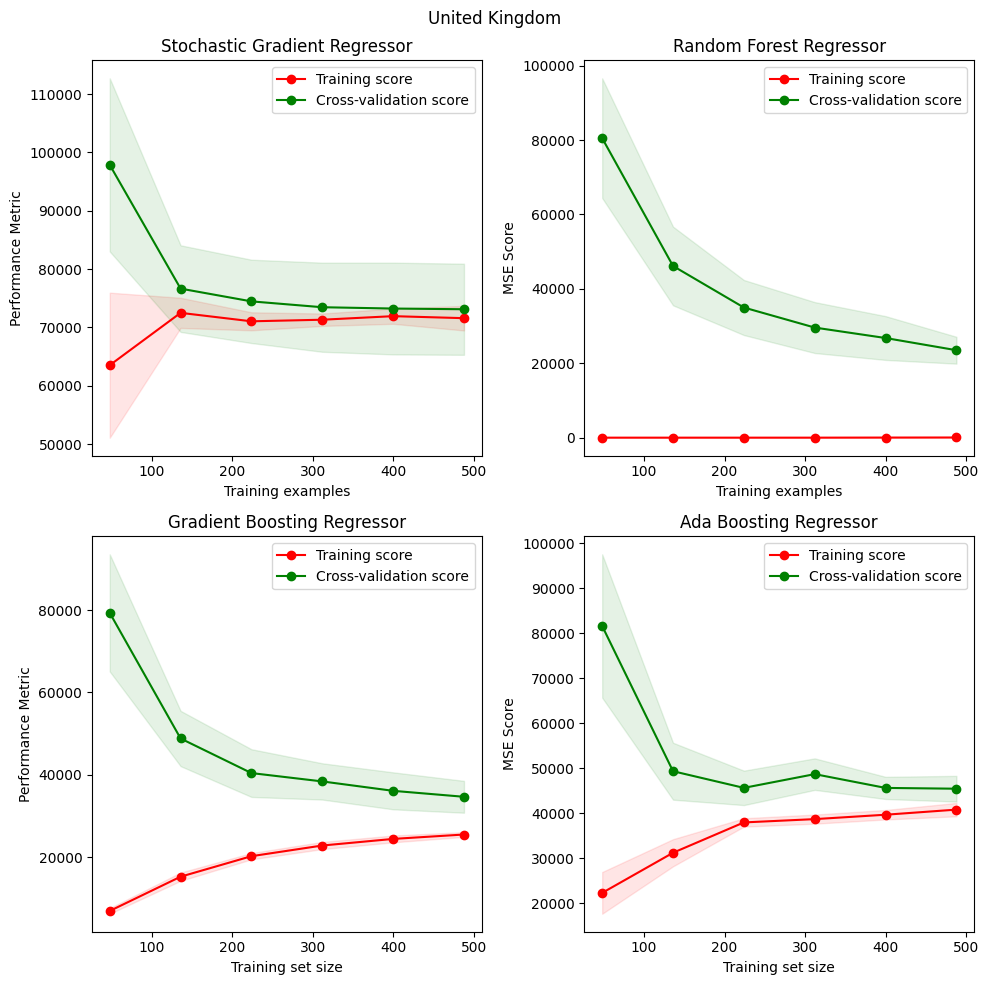

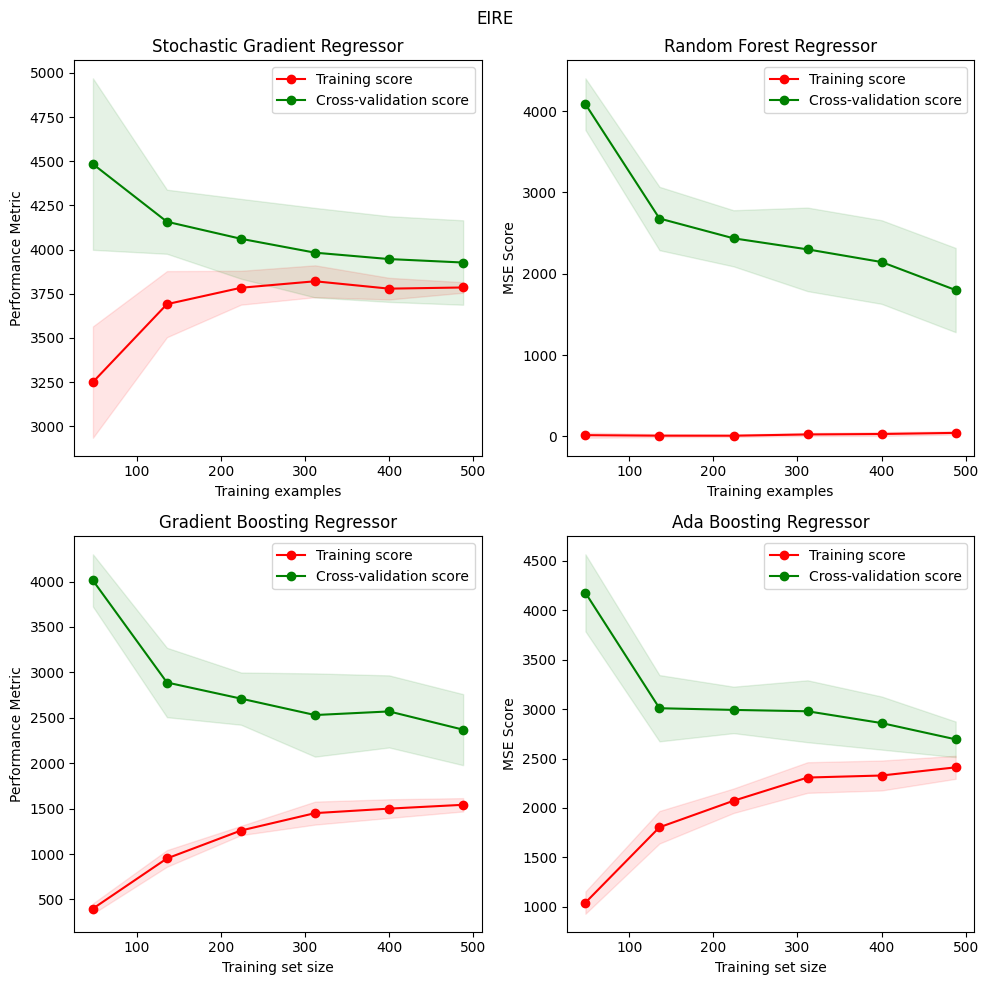

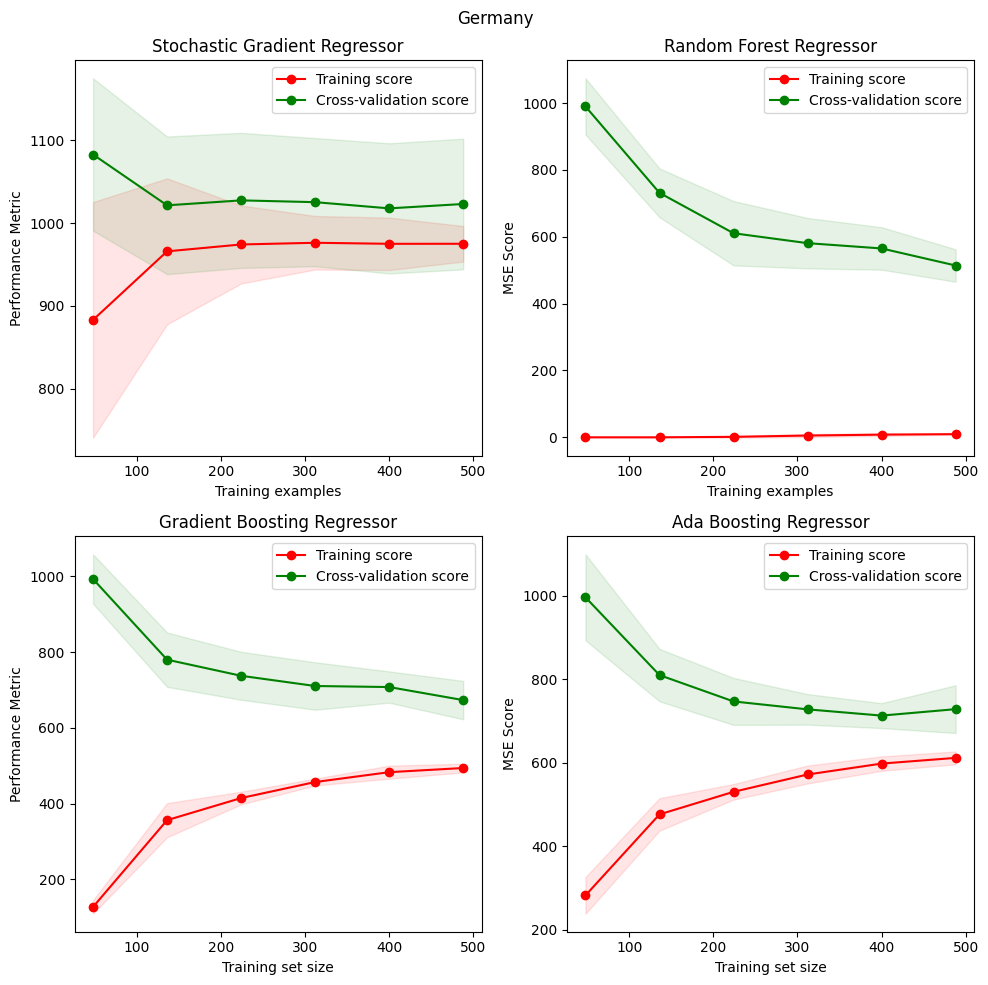

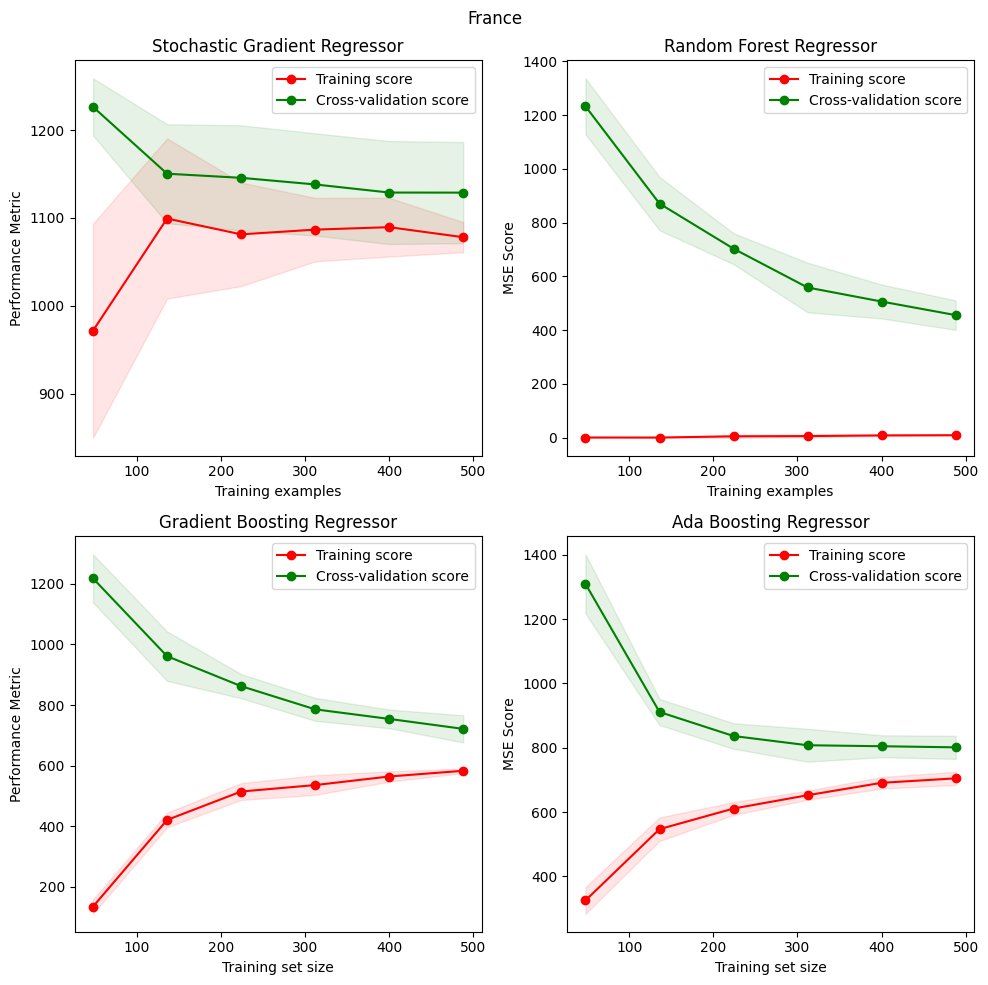

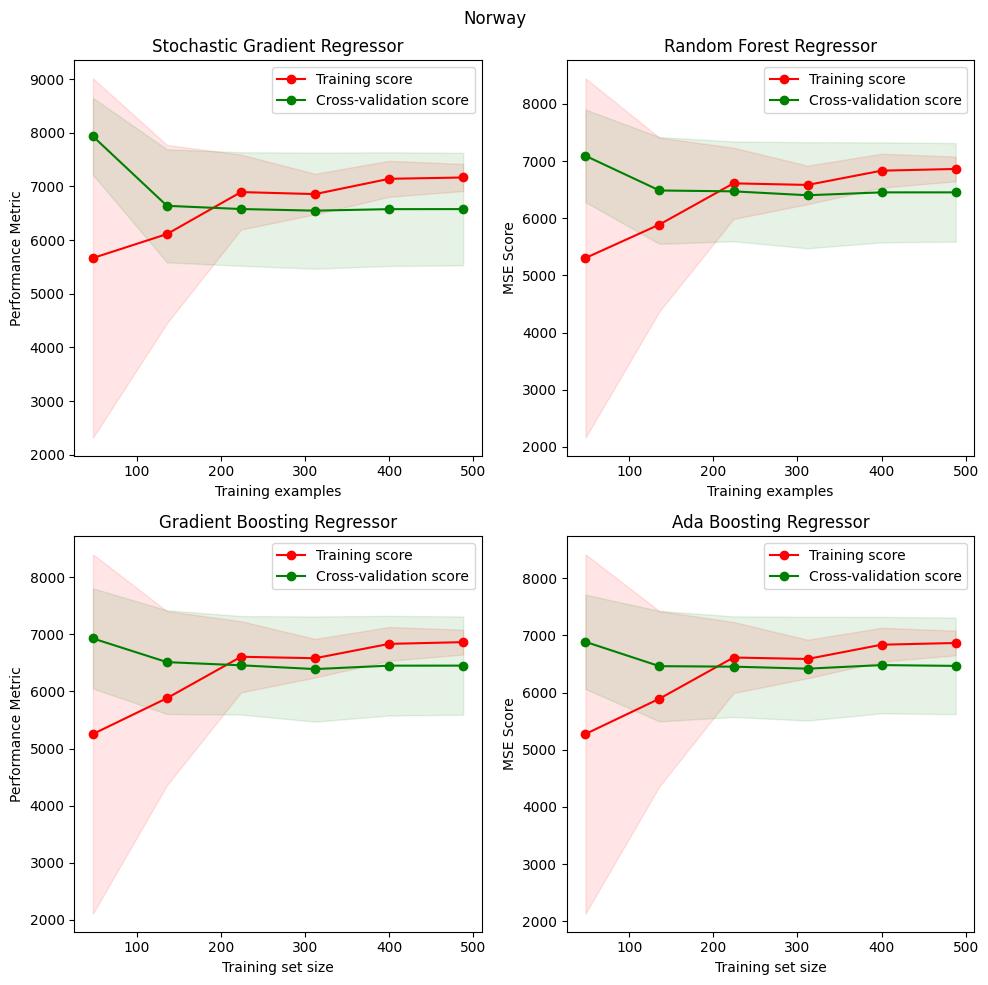

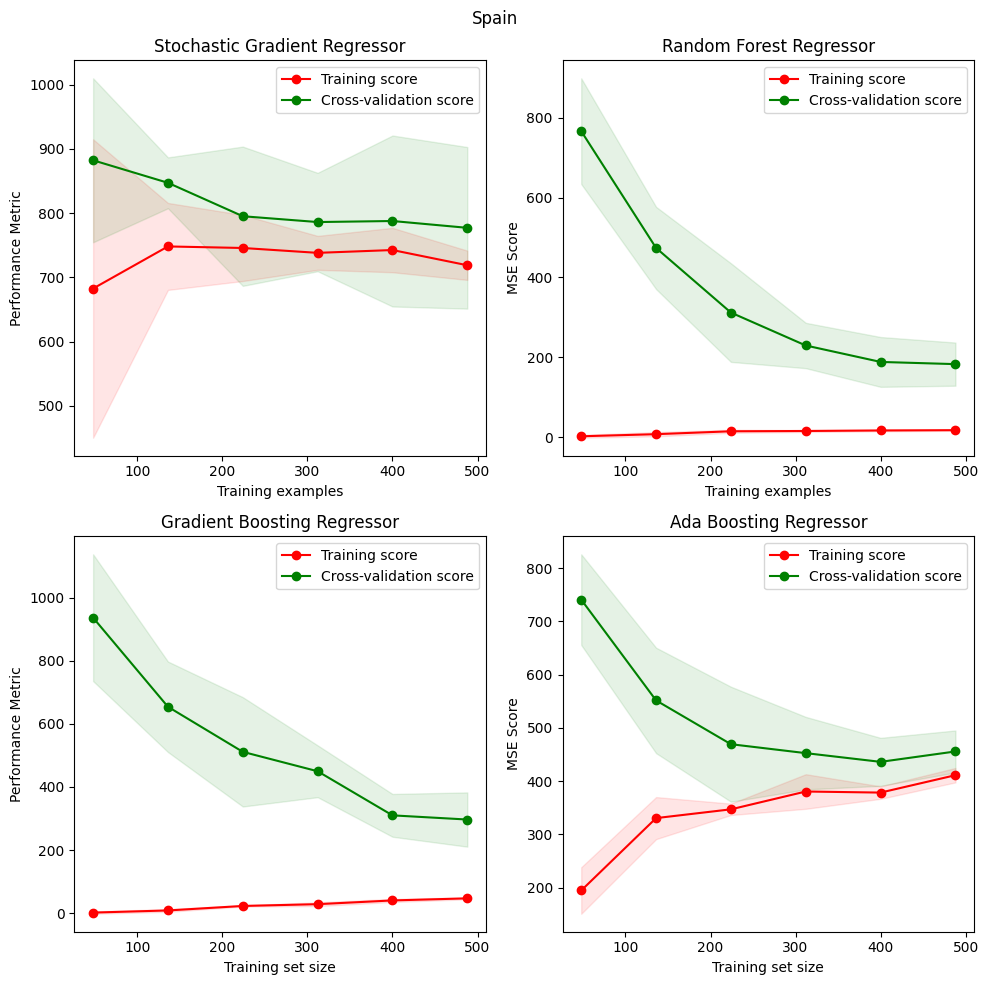

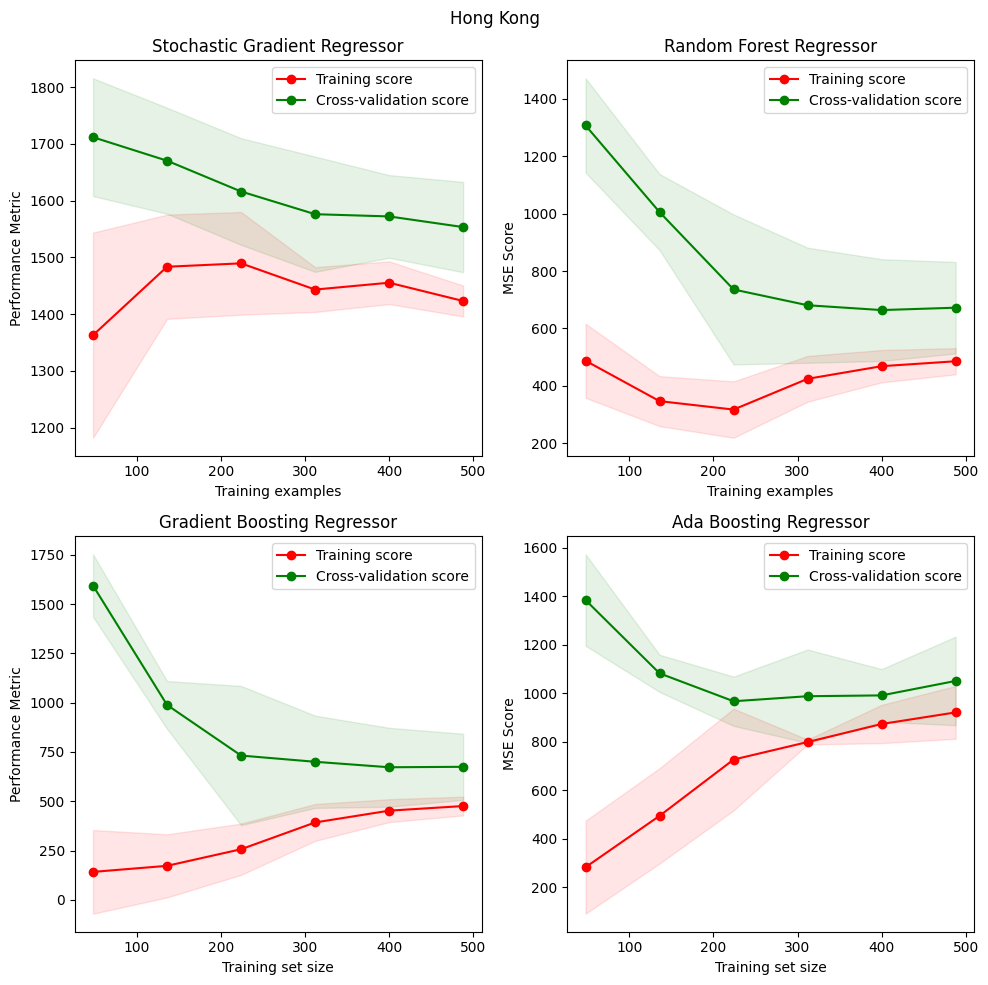

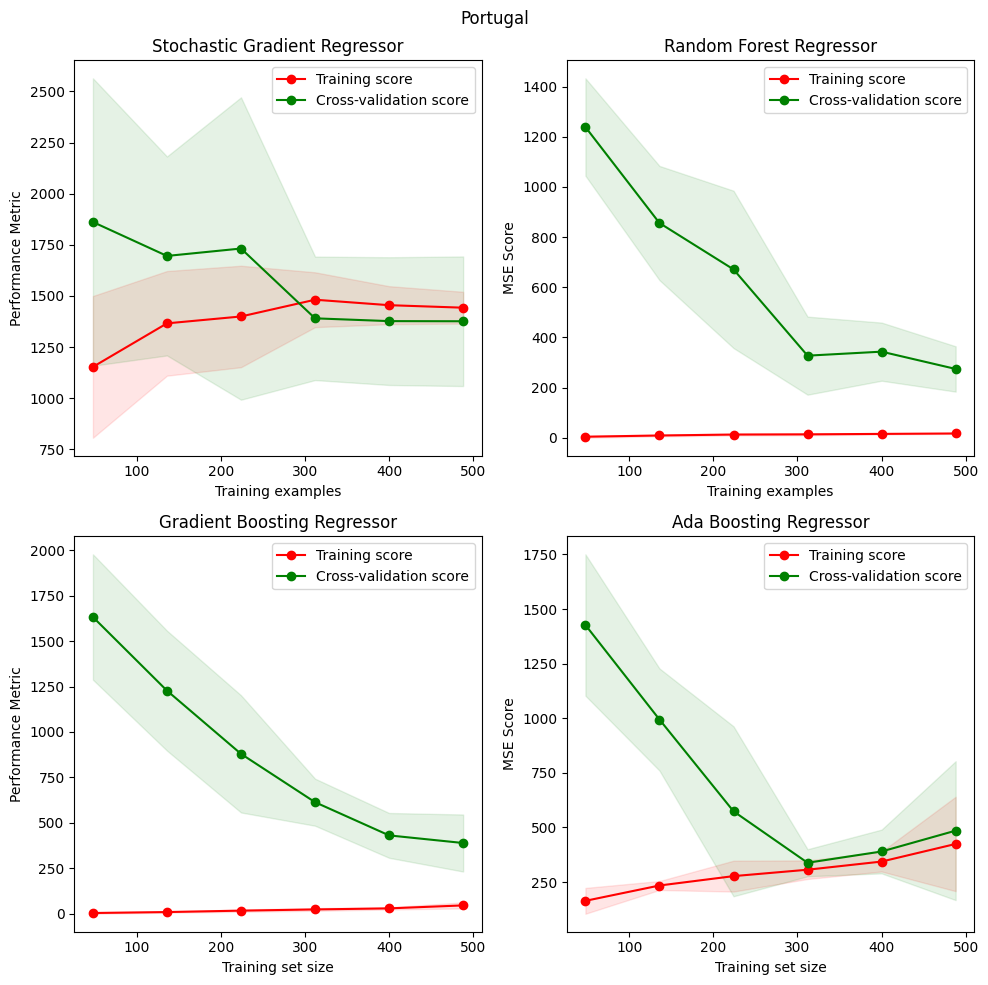

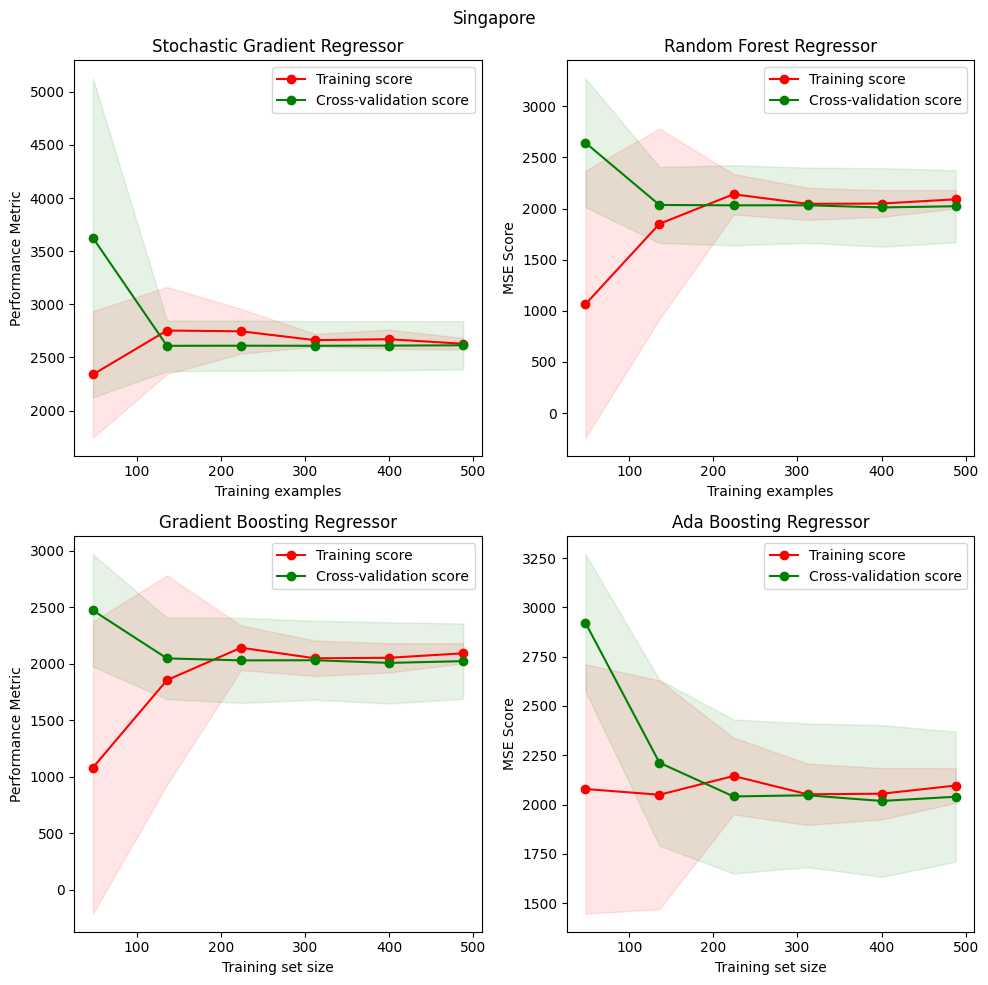

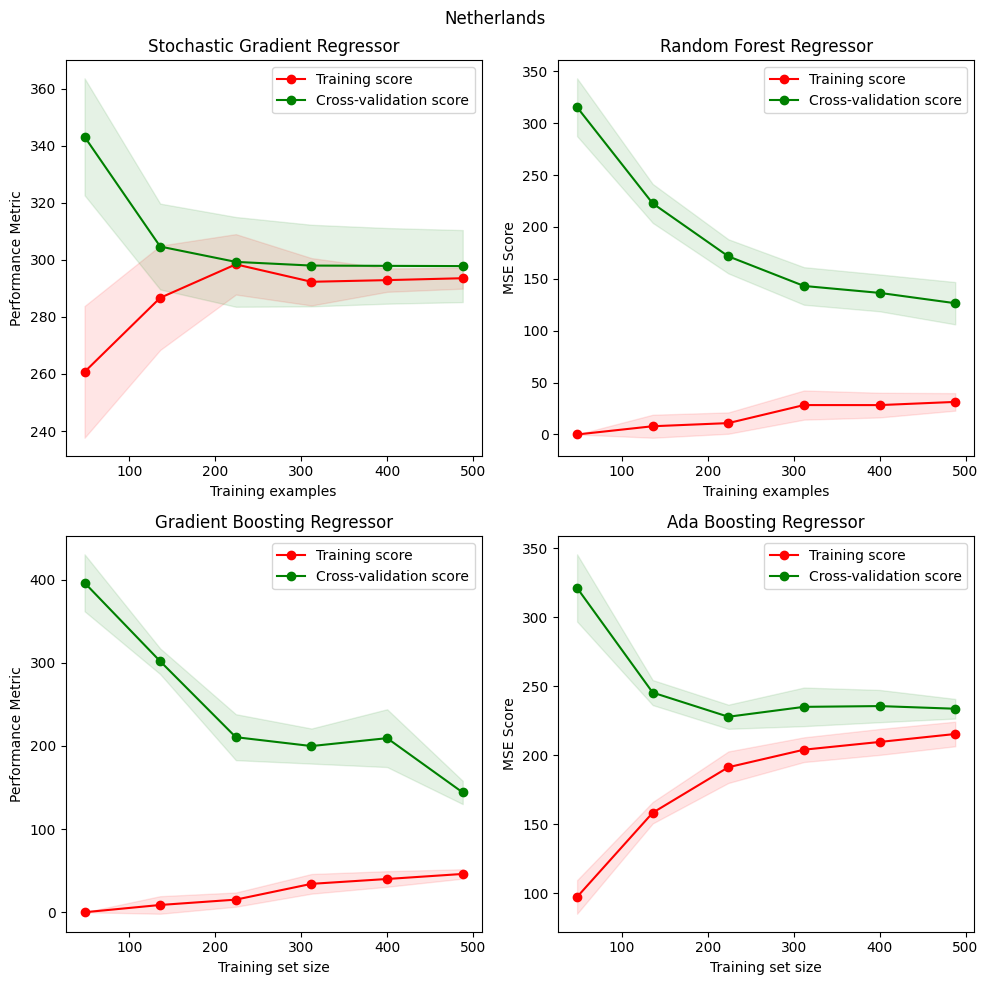

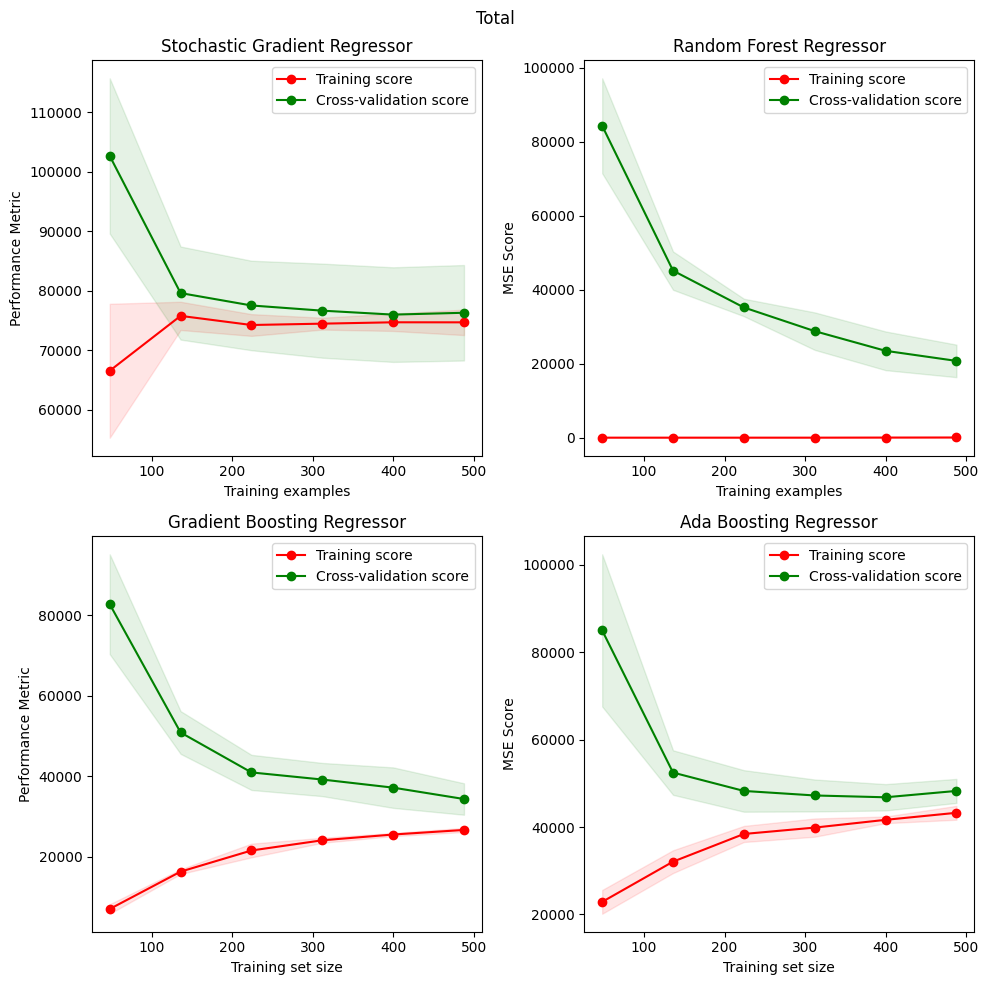

In [78]:
# Train models for each country
for country in ds['country'].unique():
    models = init_models.copy()

    temp = ds[ds['country'] == country]
    X = temp.iloc[:, 1:-2]
    y = temp['revenue_p30D']

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

    for model in models:
        pipe = Pipeline(steps=[('scaler', StandardScaler()),
                               ('reg', models[model]['regressor'])])
                        
        grid = GridSearchCV(
                        pipe,
                        param_grid=models[model]['params'],
                        scoring='neg_mean_squared_error',
                        cv=5,
                        n_jobs=-1,
                        return_train_score=True)
                
        grid.fit(X_train, y_train)

        models[model]['grid'] = grid
        
    create_learning_curves(X, y, models, country)        


In [65]:
models['RFR'] 

{'name': 'Random Forest Regressor',
 'regressor': RandomForestRegressor(random_state=42),
 'params': {'reg__n_estimators': [10, 30, 50],
  'reg__max_features': [3, 4, 5],
  'reg__bootstrap': [True, False]},
 'grid': None,
 'best_params': None}

In [59]:
    ## plot learning curves
    if save_img:
        _make_compare_plot(X, y, models=models, verbose=verbose)
        save_fig("{}_learning_curves".format(tag))
    
    ## evaluation on the validation set
    val_scores = []
    for key, model in models.items():
        y_pred = model[0].predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_pred, y_valid))
        val_scores.append(rmse)
        
    ## select best model
    bm = regressor_names[np.argmin(val_scores)]
    opt_model, params = models[bm]
    
    vocab = {"RF":"Random Forest",
             "SGD":"Stochastic Gradient",
             "GB":"Gradient Boosting",
             "ADA":"Ada Boosting"}
    
    if verbose:
        print("...best model:{}".format(vocab[bm]))

    ## retrain best model on the the full dataset
    opt_model.fit(X, y)

    ## Check the data directory
    model_path=MODEL_DIR
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    if dev:
        saved_model = os.path.join(model_path,"test-{}-model-{}.joblib".format(tag,re.sub("\.","_",str(MODEL_VERSION))))
    else:
        saved_model = os.path.join(model_path,"prod-{}-model-{}.joblib".format(tag,re.sub("\.","_",str(MODEL_VERSION))))

    ## save the best model
    joblib.dump(opt_model, saved_model)
    
    if save_img:
        if 'feature_importances_' in dir(opt_model.best_estimator_["reg"]):
            _plot_feature_importance(opt_model.best_estimator_["reg"], feature_names=feature_names, verbose=verbose)
            save_fig("{}_features_importance".format(tag))
    
    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)
            
    ## update log
    _update_train_log(tag.upper(),vocab[bm],{'rmse':max(val_scores)},runtime,MODEL_VERSION, MODEL_VERSION_NOTE, dev=dev, verbose=verbose)


NameError: name 'save_img' is not defined

### 2. Iterate on your suite of possible models by modifying data transformations, pipeline architectures, hyperparameters and other relevant factors.

### 3. Re-train your model on all of the data using the selected approach and prepare it for deployment.

### 4. Articulate your findings in a summary report.

In [ ]:
import numpy as np
import pandas as pd
#from IPython.display import Image
import matplotlib.pyplot as plt

from cslib import fetch_data, engineer_features, convert_to_ts, fetch_ts

In [ ]:
ts = convert_to_ts(fetch_data("cs-train/"))

In [ ]:
ts.head()

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
0,2017-11-01,0,0,0,0,2017-11,0.0
1,2017-11-02,0,0,0,0,2017-11,0.0
2,2017-11-03,0,0,0,0,2017-11,0.0
3,2017-11-04,0,0,0,0,2017-11,0.0
4,2017-11-05,0,0,0,0,2017-11,0.0


In [ ]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype        
---  ------           --------------  -----        
 0   date             607 non-null    datetime64[s]
 1   purchases        607 non-null    int32        
 2   unique_invoices  607 non-null    int64        
 3   unique_streams   607 non-null    int64        
 4   total_views      607 non-null    int64        
 5   year_month       607 non-null    object       
 6   revenue          607 non-null    float64      
dtypes: datetime64[s](1), float64(1), int32(1), int64(3), object(1)
memory usage: 30.9+ KB


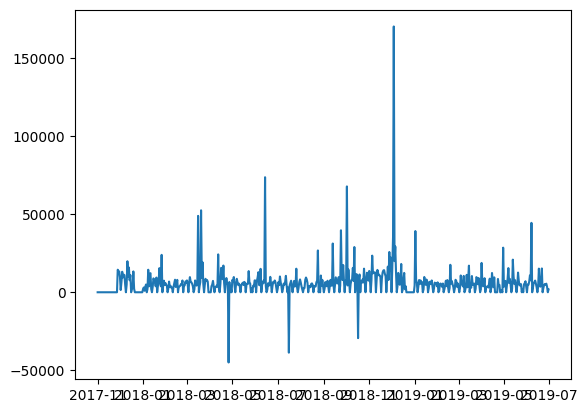

In [ ]:
#the columns in the dfts are: date, purchases, unique_invoices, unique_streams, total_views, year_month, revenue
#plot
plt.plot(ts['date'], ts['revenue'])
plt.show()



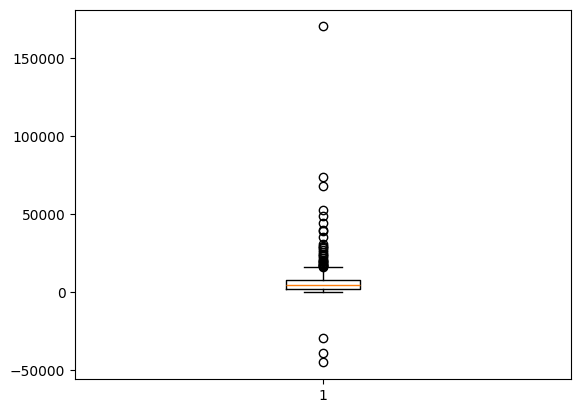

In [ ]:
#show outliers
plt.boxplot(ts['revenue'])
plt.show()

In [ ]:
#export to csv
ts.to_csv('ts-data.csv', index=False)

[EOF]